# Transfer Learning Tutorial : Unsupervised Instance-Based Approaches

In this tutorial, we are going to apply instance-based approaches to perform transfer learning.


In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from utils import show_gaussian, gaussian

# Exercise 1 : Gaussians 1D

## 1. Weighted Regression

In this exercise, we consider two domains defined on $\mathbb{R}$ : the source domain $P_S(X, Y)$ and the target domain $P_T(X, Y)$ where:

$$P_S(X) = \mathcal{N}(-1, 1)$$

$$P_T(X) = \mathcal{N}(1, 1)$$

$$P_S(Y|X=x) = P_T(Y|X=x) = \mathcal{N}(|x|, 0.5)$$

We remind the definition of the gaussian density function of mean $\mu$ and standard deviation $\sigma$:

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( \frac{-(x-\mu)^2}{2 \sigma^2} \right)$$

We consider the scenario where the learner has access to a source **labeled** sample `(Xs, ys)` of size $m=30$ drawn according to $P_S(X, Y)$ and a target **unlabeled** sample `Xt` of size $n=30$ drawn according to $P_T(X)$.

**NB** : For the tutorial purpose, we sample also the associated labels `yt` which are not available at training time but will be used to evaluate the models on the target domain.

In [6]:
def label_func(x, noise=0.1):
    return np.abs(x.ravel()) + noise * np.random.randn(len(x))

np.random.seed(0)
Xs = np.random.randn(30, 1) * 1. - 1.
Xt = np.random.randn(30, 1) * 1. + 1.
ys = label_func(Xs, 0.5)
yt = label_func(Xt, 0.5)

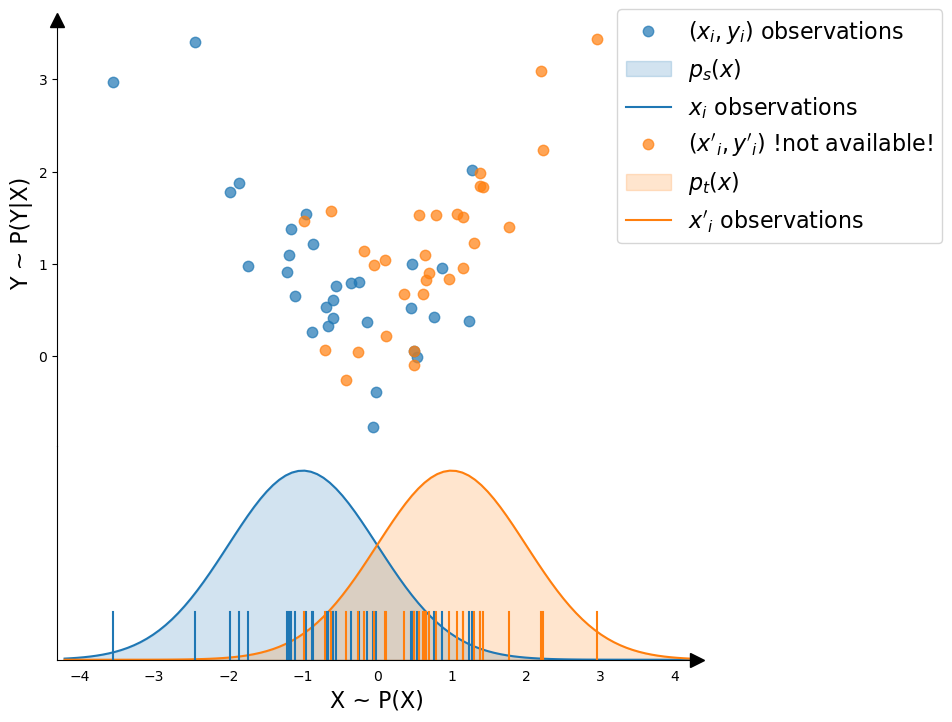

In [7]:
show_gaussian(Xs, Xt, ys, yt)

### Question 1.1 :

Use `scikit-klearn` to fit a linear model on the source labeled data `(Xs, ys)` and show the model predictions on the plot

### Question 1.2 :

Compute the source and target empirical average squared errors : 

$$\underset{(x, y) \sim \widehat{P_S}(X, Y)}{\mathbb{E}}[(h(x)-y)^2]$$

$$\underset{(x, y) \sim \widehat{P_T}(X, Y)}{\mathbb{E}}[(h(x)-y)^2]$$

Use the `show_gaussian` function to represent the errors graphically, you need to go in the `utils.py`file to see how to do it.

What do you observe ?

### Question 1.3 :

Assuming that the model error $\epsilon$ is a centered gaussian ($Y = X \beta + \epsilon$ with $\epsilon \sim \mathcal{N}(0, \sigma)$), compute the pvalue of the F-test that the source and target computed errors are drawn from the same law $\epsilon$.

For a risk $\alpha = 0.01$, can we reject the hypothesis that $\epsilon_s \sim \epsilon_t$ ?

We now want to reweight the source risk to correct the shift between domains:

### Question 1.4 :

Considering the **covariate shift** assumption:
$$ P_S(Y|X=x) = P_T(Y|X=x) $$

We can show that the traget risk is equal to the reweighted source risk:


$$\underset{(x, y) \sim P_T(X, Y)}{\mathbb{E}}[(h(x)-y)^2] = \underset{(x, y) \sim P_S(X, Y)}{\mathbb{E}}[w(x) (h(x)-y)^2] $$


With $w(x)$ the density ratio defined as:

$$w(x) = \frac{p_t(x)}{p_s(x)}$$

Obviously, we need the support of $p_t(x)$ to be included in the support of $p_s(x)$ to define $w(x)$, i.e. $\text{supp}(p_t(x)) \subset \text{supp}(p_s(x))$. This is generally implicitely assumed when considering instance-based transfer learning.

Write the proof of the previous equality.

### Question 1.5

If the distribution $p_t(x)$ and $p_s(x)$ are known (which is generally not the case) we can compute the density ratio exactly.

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( \frac{-(x-\mu)^2}{2 \sigma^2} \right)$$

In our case we have:

\begin{equation*}
\begin{split}
w(x) & = p_t(x) / p_s(x) \\
 & = \left. \exp \left( \frac{-(x-\mu_t)^2}{2 \sigma_t^2} \right) \middle/ \exp \left( \frac{-(x-\mu_s)^2}{2 \sigma_s^2} \right) \right. \\
 & = \exp \left( \frac{-(x-1)^2}{2} + \frac{(x+1)^2}{2} \right) \\
 & = \exp \left( 2 x \right) \\
\end{split}
\end{equation*}

Now that we have expressed the density ratio $w(x)$ as a function of $x$, we write a python function for it. Then, we plot a comparison of the empirical source distribution with its reweighted counterpart.

In [ ]:
def density_ratio(x):
    return np.exp(2 * x.ravel())

In [ ]:
lin = np.linspace(-4, 4, 1000)
weights = density_ratio(lin)

plt.figure(figsize=(8, 3))
plt.fill_between(lin, gaussian(lin, mu=-1)*100., label=r"$p_s(x)$", alpha=0.3, edgecolor="C0")
plt.fill_between(lin, gaussian(lin, mu=1)*100., label=r"$p_t(x)$", alpha=0.3, edgecolor="C1")
plt.plot(lin, weights, c="C0", label=r"$w(x) = \exp(2 x)$")
plt.xlabel("X"); plt.ylabel("Density Ratio", fontsize=14); plt.legend(fontsize=16); plt.ylim(0, 100); plt.show()

In [ ]:
# Plot a kernel density estimation of the densities
show_gaussian(Xs, Xt) 
show_gaussian(Xs, Xt, weights=density_ratio(Xs))

What can be said about the reweighted source density ? 

### Question 1.6

Now that we have computed $w(x)$ we can give a "debiased" estimation of the target risk by reweighting the source risk (cf Equation 1).

Compute a reweighted average of the source errors of the "source only" model and compare it to the target average error.

### Question 1.7

Compute the F statistic 

Can we still reject the hypothesis that $\epsilon_s \sim \epsilon_t$ ?

### Question 1.8

We know want to fit the linear regression model based on the reweighted source risk. We want to compute analyticaly the linear regression solution $\beta^*$.

The close-form solution for standard linear regression model is written:

$$\beta^* = (X^T X)^{-1} X^T y$$

For the reweighted linear regression model, show that the close-form solution becomes:

$$\beta^* = (X^T \Delta X)^{-1} X^T \Delta Y $$

With $\Delta = \text{diag}(w_1, ..., w_m)$, with $w_i = w(x_i)$.

To learn the coeficients $\beta^*$ with scikit-learn, we can use the `sample_weight` argument of the `fit` method:

We now compare the coeficents of the source only model and the reweighted one:

What can be said about the new coeficients

### Question 1.10

Plot the model predictions and compute the new target risk. What do you observe?

In [ ]:
show_gaussian(Xs, Xt, ys, yt, model_reweighted, density_ratio(Xs), show_error_tgt=True)

We now compare the target errors of the source only model and the reweighted model. What do we observe ?

In [ ]:
yps = model_source_only.predict(Xt)
err_tgt_1 = np.mean(np.square(ypt - yt))

ypt = model_reweighted.predict(Xt)
err_tgt_2 = np.mean(np.square(ypt - yt))

print("Target average squared error of the source only model: %.4f"%err_tgt_1)
print("Target average squared error of the reweighted model: %.4f"%err_tgt_2)

When looking at the true target model $P_T(Y|X)$, what can be said about the emprical target error above?

In this case, we compute $w(x)$ anatycally considering that $p_t(x)$ and $p_s(x)$ are known. Do you think this is a realistic assumption ?

In the following, we will see which reweighting approaches can be considered when $p_t(x)$ and $p_s(x)$ are only partially known through empirical samples.

## 2. Instance-based Approaches

In the following, we consider that we have access to both input samples $X_S \sim P_S(X)$ and $X_T \sim P_T(X)$ of respective size $m=n=30$. We also have access to the source label $y_S$ drawn accoring to $P_S(Y|X)$.

### Question 2.1 : PDE

One way to estimate the density ratio $w(x)$ based on empirical source and target input samples $X_S, X_T$ is to perform both density estimations : $\widehat{p_s}(x)$ and $\widehat{p_t}(x)$.

The Paramatric Density-Estimation (PDE) method consists in assuming a prior input distribution with densities $p_s(\theta_s, x)$, $p_t(\theta_t, x)$ for the source and target domains respectively. The parameters $\theta_s$ and $\theta_t$ of the distributions are then estimated through Maximum-Likelihood estimation.

\begin{gather*}
    \widehat{\theta_s^*} = \underset{\theta_s \in \Theta_s}{\text{argmin}} \sum_{x_i \in X_S} \log( p_s(\theta_s, x_i) ) \\
    \widehat{\theta_t^*} = \underset{\theta_t \in \Theta_t}{\text{argmin}} \sum_{x'_i \in X_T} \log( p_t(\theta_t, x'_i) ) \\
    \widehat{w}(x_i) = \frac{p_t(\widehat{\theta_t^*}, x_i)}{p_s(\widehat{\theta_s^*}, x_i)}
\end{gather*}

In our case, we assume a gaussian model and compute the density ratio as follows

In [ ]:
def pde(Xs, Xt):
    mu_src = np.mean(Xs)
    sigma_src = np.std(Xs)

    mu_tgt = np.mean(Xt)
    sigma_tgt = np.std(Xt)

    ps_Xs = gaussian(Xs, mu=mu_src, s=sigma_src) # =  1/(2*np.pi*s**2)**0.5 * np.exp(-(Xs-mu)**2 / (2*s**2))
    pt_Xs = gaussian(Xs, mu=mu_tgt, s=sigma_tgt)
    return  pt_Xs / ps_Xs

weights = pde(Xs, Xt)

We now compare the true density ratio with the estimated one and plot the reweighted density:

In [ ]:
args = np.argsort(Xs.ravel()).ravel()
plt.plot(Xs[args], density_ratio(Xs[args]), label=r"$w(x)$")
plt.plot(Xs, weights, ".", c="black", label=r'$\widehat{w}(x)$')
plt.xlabel("X"); plt.ylabel("Weight"); plt.legend(fontsize=16); plt.show()

show_gaussian(Xs, Xt, weights=weights)

We can try to modify the number of source and target instances to observe the impact on the estimation of the density ratio:

In [ ]:
np.random.seed(123)
m = 100; n = 100

Xsm = np.random.randn(m, 1) - 1.; Xtn = np.random.randn(n, 1) + 1.;
weights = pde(Xsm, Xtn)

args = np.argsort(Xsm.ravel()).ravel()
plt.plot(Xsm[args], density_ratio(Xsm[args]), label=r"$w(x)$")
plt.plot(Xsm, weights, ".", c="black", label=r'$\widehat{w}(x)$')
plt.xlabel("X"); plt.ylabel("Weight"); plt.legend(fontsize=16); plt.show()

show_gaussian(Xsm, Xtn, weights=weights)

We now modify the input distributions:

In [ ]:
np.random.seed(123)
m = 300; n = 300

Xsm = np.random.exponential(1., (n, 1)) - 1.; Xtn = np.random.exponential(1., (m, 1)) + 1.;
weights = pde(Xsm, Xtn)

args = np.argsort(Xsm.ravel()).ravel()
plt.plot(Xsm[args], density_ratio(Xsm[args]), label=r"$w(x)$")
plt.plot(Xsm, weights, ".", c="black", label=r'$\widehat{w}(x)$')
plt.xlabel("X"); plt.ylabel("Weight"); plt.legend(fontsize=16); plt.show()

show_gaussian(Xsm, Xtn, weights=weights)

What do we observe? Is the gaussian assumption realistic in real scenario ?

### Question 2.2 : KDE (1)

In many cases, the source and target input distributions are not gaussians, to estimate the densities, one can then use a kernel density approach:

Let's consider $k : \mathcal{X} \times \mathcal{X} \to \mathbb{R}_+$ a kernel function. The learner computes estimations of the densities $p_s(x)$, $p_t(x)$ as sums of kernels centered in each observation $x_i \in X_S$ (resp $x'_i \in X_T$).
\begin{gather*}
    \widehat{p_s}(x) = C_s \sum_{x_i \in X_S} k(x, x_i) \\
    \widehat{p_t}(x) = C_t \sum_{x'_i \in X_T} k(x, x'_i) \\
    \widehat{w}(x_i) = \frac{\widehat{p_t}(x_i)}{\widehat{p_s}(x_i)}
\end{gather*}

A typical kernel function is the Gaussian kernel: $k : (x, x') \to \exp\left(-\frac{||x-x'||^2_2}{2 \sigma^2}\right)$. $\sigma \in \mathbb{R_+^*}$ is the kernel bandwidth and can be chosen through Maximum Likelihood estimation.

Compute the Kernel Density Estimation (KDE) with gaussians kernels for the source and target densities, plot the estimated densities and compare the obtained weights to the theoretical one.

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

def kde(centers, x, sigma=0.5):
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    # dist is a pairwise distance matrix of shape (len(centers), len(x))
    dist = (1./np.sqrt( 2. * np.pi * sigma**2 )) * rbf_kernel(centers, x, gamma=1/(2 * sigma))
    return dist.mean(0) # Average over the centers

def log_likelihood(p):
    return np.mean(np.log(p))

In [ ]:
sigma = 0.5  # kernel bandwidth

x = np.linspace(-4.2, 4.2, 100)
ps_x = kde(Xs, x, sigma=sigma)
pt_x = kde(Xt, x, sigma=sigma)

plt.figure(figsize=(8, 3))
plt.plot(x, ps_x); plt.plot(x, pt_x)
plt.fill_between(x, ps_x, alpha=0.2); plt.fill_between(x, pt_x, alpha=0.2)
plt.show()

In [ ]:
weights = (kde(Xt, Xs, sigma=sigma) /
           kde(Xs, Xs, sigma=sigma))

args = np.argsort(Xs.ravel()).ravel()
plt.plot(Xs[args], density_ratio(Xs[args]), label=r"$w(x)$")
plt.plot(Xs, weights, ".", c="black", label=r'$\widehat{w}(x)$')
plt.xlabel("X"); plt.ylabel("Weight"); plt.legend(fontsize=16); plt.show()
show_gaussian(Xs, Xt, weights=weights)

In [ ]:
ll_src = log_likelihood(kde(Xs, Xs, sigma=sigma))

print("Source KDE Log likelihood: %.3f"%ll_src)

To finish, I suggest that to try to implement the code described in the folloing paper 

**Fernando, B., Habrard, A., Sebban, M., and Tuytelaars, T. (2013).** \
*Unsupervised visual domain adaptation using subspace alignment.* \
In Proceedings of the IEEE international conference on computer vision, pages 2960–2967.